# Group Dynamics

This document takes a look at group dynamics.

## Setup

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import networkx as nx
from matplotlib.patches import FancyArrowPatch

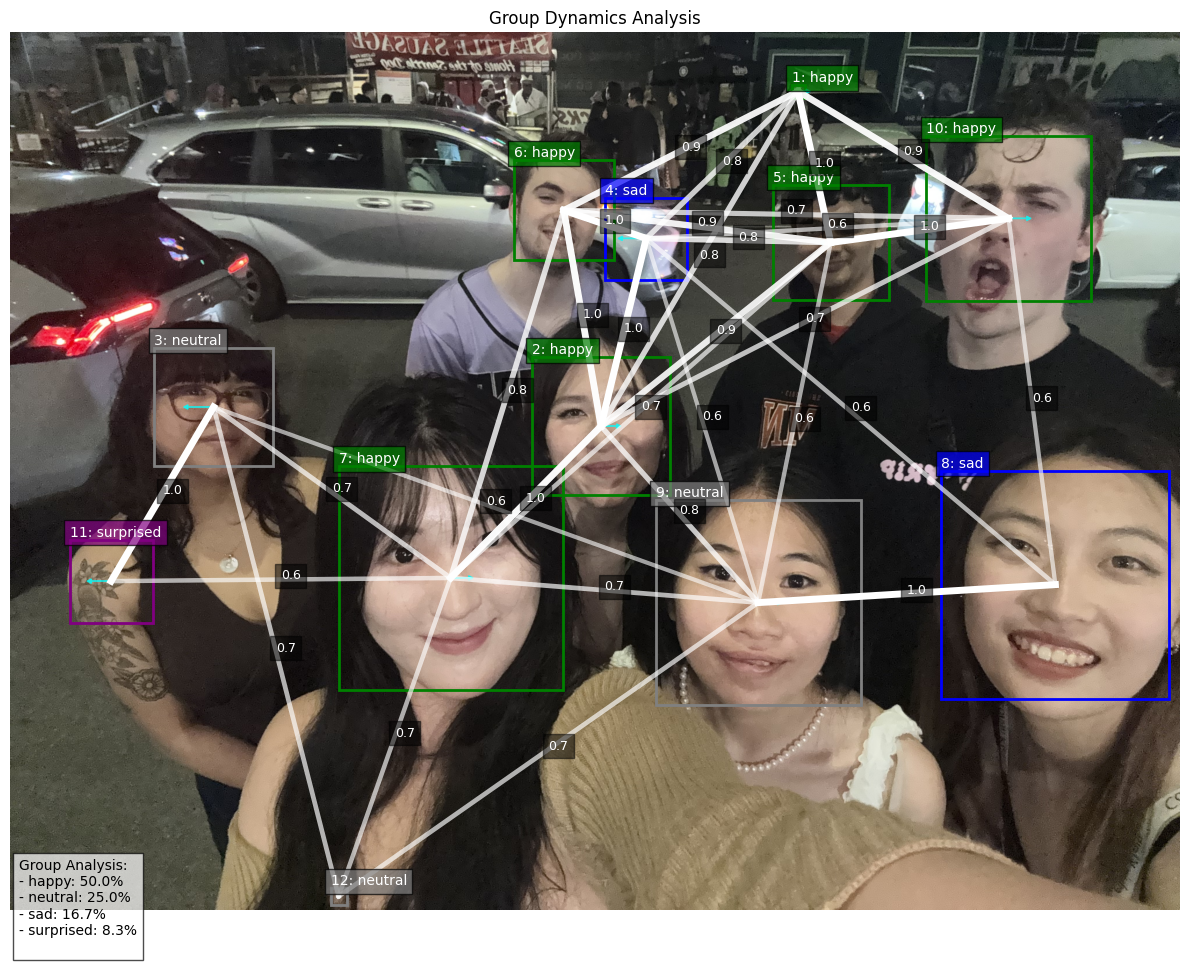

Group Dynamics Analysis Results:
- Detected 12 people in the image
- Group emotions:
  * happy: 50.0%
  * neutral: 25.0%
  * sad: 16.7%
  * surprised: 8.3%
- Strong relationships detected:
  * Person 1 and Person 5: 1.00
  * Person 2 and Person 4: 1.00
  * Person 3 and Person 11: 1.00
  * Person 4 and Person 6: 1.00
  * Person 5 and Person 10: 1.00
  * Person 8 and Person 9: 1.00
  * Person 2 and Person 7: 0.98
  * Person 2 and Person 6: 0.97
  * Person 1 and Person 10: 0.95
  * Person 1 and Person 6: 0.93
  * Person 5 and Person 6: 0.92
  * Person 2 and Person 5: 0.90
  * Person 4 and Person 5: 0.81
  * Person 6 and Person 7: 0.80
  * Person 1 and Person 2: 0.80
  * Person 1 and Person 4: 0.78
  * Person 2 and Person 9: 0.76
  * Person 6 and Person 10: 0.74
  * Person 2 and Person 10: 0.73


In [2]:
def detect_faces(image_path):
    """Detect faces in an image and return face images and their boxes"""
    import cv2
    import numpy as np
    
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Couldn't read image from {image_path}")
        return [], [], None
    
    # Convert to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load the face detector - using a simple OpenCV one
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Detect faces
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces_rect = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    
    # Process results
    faces = []
    boxes = []
    
    for (x, y, w, h) in faces_rect:
        face_img = image_rgb[y:y+h, x:x+w]
        faces.append(face_img)
        boxes.append([x, y, x+w, y+h])
    
    return faces, boxes, image_rgb

# Define a simple emotion detector
def detect_emotion(face_image):
    """Simple mock emotion detector (in real app, use a trained model)"""
    # In a real application, you would use a pre-trained emotion recognition model
    # For this example, we'll simply return a random emotion
    emotions = ['happy', 'sad', 'neutral', 'surprised', 'angry']
    weights = [0.5, 0.1, 0.2, 0.1, 0.1]  # Make happy more likely for demo
    return np.random.choice(emotions, p=weights)

# Define simplified gaze detection
def analyze_gaze(face_image):
    """Simplified gaze detection (in real app, use a trained model)"""
    # In a real application, you would use a pre-trained gaze detection model
    # For this example, we'll return random but consistent gaze directions
    h, w = face_image.shape[:2]
    
    # Simple approach: use face position to simulate gaze
    # Compute a hash of the face image to get consistent results for same face
    face_hash = hash(face_image.tobytes()) % 100
    
    # Use the hash to determine gaze direction (-1 to 1 range)
    gaze_x = (face_hash / 100 * 2) - 1
    
    # Create annotated face image
    face_with_annotation = face_image.copy()
    cv2.arrowedLine(
        face_with_annotation,
        (w//2, h//2),
        (w//2 + int(gaze_x * w//4), h//2),
        (0, 255, 0),
        2
    )
    
    return np.array([gaze_x, 0]), face_with_annotation

# Calculate spatial proximity (from notebook 4)
def calculate_face_centers(boxes):
    """Calculate center points of detected faces"""
    centers = []
    for box in boxes:
        x1, y1, x2, y2 = box
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        centers.append((center_x, center_y))
    return centers

def calculate_proximity_matrix(centers):
    """Calculate pairwise distances between face centers"""
    num_faces = len(centers)
    proximity_matrix = np.zeros((num_faces, num_faces))
    
    for i in range(num_faces):
        for j in range(num_faces):
            if i != j:
                proximity_matrix[i, j] = distance.euclidean(centers[i], centers[j])
    
    return proximity_matrix

def normalize_proximity_matrix(proximity_matrix):
    """Normalize the proximity matrix to a 0-1 scale"""
    max_distance = np.max(proximity_matrix)
    if max_distance > 0:
        normalized_matrix = proximity_matrix / max_distance
    else:
        normalized_matrix = proximity_matrix
    
    # Convert to proximity (closer = higher value)
    proximity_matrix = 1 - normalized_matrix
    np.fill_diagonal(proximity_matrix, 0)  # No proximity to self
    
    return proximity_matrix

def find_gaze_targets(boxes, centers, gaze_vectors):
    """Find potential gaze targets based on gaze vectors"""
    num_faces = len(boxes)
    gaze_targets = [None] * num_faces
    
    for i in range(num_faces):
        gaze_x = gaze_vectors[i][0]
        
        # Skip if gaze is neutral (looking straight ahead)
        if abs(gaze_x) < 0.2:
            continue
        
        # Determine which side the person is looking towards
        looking_right = gaze_x > 0
        
        # Find potential targets on that side
        potential_targets = []
        for j in range(num_faces):
            if i == j:
                continue
                
            # Check if face j is on the correct side of face i
            target_is_right = centers[j][0] > centers[i][0]
            
            if (looking_right and target_is_right) or (not looking_right and not target_is_right):
                # Calculate angle between gaze direction and potential target
                dx = centers[j][0] - centers[i][0]
                dy = centers[j][1] - centers[i][1]
                distance_to_target = np.sqrt(dx**2 + dy**2)
                
                # Normalize to create a score (closer is better)
                score = 1 / (1 + distance_to_target / 100)
                potential_targets.append((j, score))
        
        # Select the highest scoring target if any exist
        if potential_targets:
            best_target = max(potential_targets, key=lambda x: x[1])
            gaze_targets[i] = best_target[0]
    
    return gaze_targets

def analyze_group_relationships(emotions, proximity_matrix, gaze_targets):
    """Analyze relationships between individuals in the group"""
    num_people = len(emotions)
    relationships = np.zeros((num_people, num_people))
    
    for i in range(num_people):
        for j in range(num_people):
            if i == j:
                continue
                
            # Start with base proximity score
            relationship_score = proximity_matrix[i, j]
            
            # Boost if i is looking at j
            if gaze_targets[i] == j:
                relationship_score += 0.3
                
            # Boost if both people have same emotion
            if emotions[i] == emotions[j]:
                relationship_score += 0.2
                
            # Boost if both looking at each other
            if gaze_targets[i] == j and gaze_targets[j] == i:
                relationship_score += 0.4
                
            relationships[i, j] = min(relationship_score, 1.0)  # Cap at 1.0
    
    return relationships

def analyze_group_dynamics(image_path):
    """Analyze group dynamics in an image"""
    # Detect faces
    faces, boxes, image = detect_faces(image_path)
    
    if len(faces) < 2:
        print("Need at least 2 faces to analyze group dynamics!")
        return None
    
    # Calculate centers
    centers = calculate_face_centers(boxes)
    
    # Analyze emotions
    emotions = [detect_emotion(face) for face in faces]
    
    # Analyze gaze
    gaze_results = [analyze_gaze(face) for face in faces]
    gaze_vectors = [result[0] for result in gaze_results]
    
    # Calculate proximity
    proximity_matrix = calculate_proximity_matrix(centers)
    normalized_proximity = normalize_proximity_matrix(proximity_matrix)
    
    # Find potential gaze targets
    gaze_targets = find_gaze_targets(boxes, centers, gaze_vectors)
    
    # Analyze relationships
    relationship_matrix = analyze_group_relationships(emotions, normalized_proximity, gaze_targets)
    
    # Prepare results dictionary
    results = {
        'image': image,
        'faces': faces,
        'boxes': boxes,
        'centers': centers,
        'emotions': emotions,
        'gaze_vectors': gaze_vectors,
        'proximity_matrix': normalized_proximity,
        'gaze_targets': gaze_targets,
        'relationship_matrix': relationship_matrix
    }
    
    return results

def visualize_group_dynamics(results):
    """Visualize group dynamics analysis results"""
    if results is None:
        return
        
    image = results['image']
    boxes = results['boxes']
    centers = results['centers']
    emotions = results['emotions']
    gaze_vectors = results['gaze_vectors']
    gaze_targets = results['gaze_targets']
    relationship_matrix = results['relationship_matrix']
    
    plt.figure(figsize=(12, 10))
    plt.imshow(image)
    
    # Define emotion colors
    emotion_colors = {
        'happy': 'green',
        'sad': 'blue',
        'neutral': 'gray',
        'surprised': 'purple',
        'angry': 'red'
    }
    
    # Draw boxes and emotion labels
    for i, (box, emotion) in enumerate(zip(boxes, emotions)):
        x1, y1, x2, y2 = box
        color = emotion_colors.get(emotion, 'yellow')
        
        # Draw box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           fill=False, color=color, linewidth=2)
        plt.gca().add_patch(rect)
        
        # Show emotion label
        plt.text(x1, y1-10, f"{i+1}: {emotion}", color='white', fontsize=10,
                 bbox=dict(facecolor=color, alpha=0.7))
    
    # Draw gaze directions
    for i, (center, gaze_vector) in enumerate(zip(centers, gaze_vectors)):
        # Skip if gaze is neutral
        if abs(gaze_vector[0]) < 0.2:
            continue
            
        # Draw gaze arrow
        dx = gaze_vector[0] * 100  # Scale for visibility
        dy = 0  # We're only using horizontal gaze for simplicity
        
        plt.arrow(center[0], center[1], dx, dy, 
                 head_width=15, head_length=15, fc='cyan', ec='cyan', alpha=0.7)
    
    # Draw relationship lines
    for i in range(len(boxes)):
        for j in range(i+1, len(boxes)):
            relationship_strength = relationship_matrix[i, j]
            
            # Only draw strong relationships
            if relationship_strength > 0.6:
                plt.plot([centers[i][0], centers[j][0]], 
                         [centers[i][1], centers[j][1]], 
                         'w-', alpha=relationship_strength, 
                         linewidth=relationship_strength*5)
                
                # Show relationship strength
                mid_x = (centers[i][0] + centers[j][0]) // 2
                mid_y = (centers[i][1] + centers[j][1]) // 2
                plt.text(mid_x, mid_y, f"{relationship_strength:.1f}", 
                         color='white', fontsize=9,
                         bbox=dict(facecolor='black', alpha=0.5))
    
    # Add summary text
    group_emotions = {}
    for emotion in emotions:
        group_emotions[emotion] = group_emotions.get(emotion, 0) + 1
    
    summary_text = "Group Analysis:\n"
    for emotion, count in group_emotions.items():
        percentage = count / len(emotions) * 100
        summary_text += f"- {emotion}: {percentage:.1f}%\n"
    
    plt.figtext(0.02, 0.02, summary_text, bbox=dict(facecolor='white', alpha=0.7))
    
    plt.title("Group Dynamics Analysis")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Test on an image if available
def test_group_dynamics(image_path):
    """Test group dynamics analysis on an image"""
    results = analyze_group_dynamics(image_path)
    if results:
        visualize_group_dynamics(results)
        
        # Print insights
        print("Group Dynamics Analysis Results:")
        print(f"- Detected {len(results['faces'])} people in the image")
        
        # Count emotions
        emotion_counts = {}
        for emotion in results['emotions']:
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
        
        print("- Group emotions:")
        for emotion, count in emotion_counts.items():
            percentage = count / len(results['emotions']) * 100
            print(f"  * {emotion}: {percentage:.1f}%")
        
        # Find strongest relationships
        relationships = results['relationship_matrix']
        strongest = []
        
        for i in range(len(relationships)):
            for j in range(i+1, len(relationships)):
                if relationships[i, j] > 0.7:
                    strongest.append((i, j, relationships[i, j]))
        
        if strongest:
            print("- Strong relationships detected:")
            for i, j, strength in sorted(strongest, key=lambda x: x[2], reverse=True):
                print(f"  * Person {i+1} and Person {j+1}: {strength:.2f}")

# Test on an image if available
if os.path.exists('C:/Users/jaden/Documents/GitHub/TECHIN-513/finalProject3/data/test_images'):
    test_files = os.listdir('C:/Users/jaden/Documents/GitHub/TECHIN-513/finalProject3/data/test_images')
    if len(test_files) > 0:
        test_image = os.path.join('C:/Users/jaden/Documents/GitHub/TECHIN-513/finalProject3/data/test_images', test_files[0])
        test_group_dynamics(test_image)
    else:
        print("No test images found!")
else:
    print("Test images folder not found!")